# Model Development

In this notebook, we will develop a Kriging model using the `NYS Oil & Gas Wells` to predict optimal drilling locations for oil and gas in **New York State**. Using geological and production data, we will explore spatial interpolation techniques to accurately estimate potential production sites. The process will involve building the Kriging model and refining it through regularization and hyperparameter tuning.

By the end of this notebook, we will have established a robust model ready for evaluation, aiming to identify the most effective approach for predicting where to drill for oil and gas.

### Loading Tools and Data

count    3,691.00
mean    13,417.05
std      8,529.29
min      2,168.00
25%      5,756.00
50%     11,598.00
75%     20,423.50
max     31,710.00
Name: gas_prod, dtype: float64
------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3691 entries, 0 to 3690
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_prod   3691 non-null   float64
 1   well       3691 non-null   object 
 2   status     3691 non-null   object 
 3   depth      3691 non-null   float64
 4   elevation  3691 non-null   float64
 5   longitude  3691 non-null   float64
 6   latitude   3691 non-null   float64
 7   field      3691 non-null   object 
 8   geology    3691 non-null   object 
dtypes: float64(5), object(4)
memory usage: 259.6+ KB
None


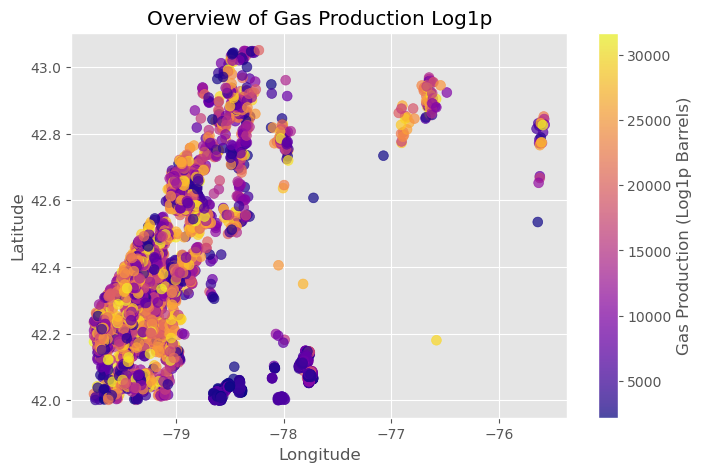

,gas_prod,well,status,depth,elevation,longitude,latitude,field,geology
0,"5,455.00",gas development,plugged abandoned,"1,294.00",851.00,-78.48,42.94,Alden-Lancaster,Medina
1,"4,741.00",gas development,plugged abandoned,"1,818.00",535.00,-76.66,42.89,West Auburn,Queenston
2,"28,116.00",gas development,inactive,"1,425.00",640.00,-78.92,42.73,Orchard Park-Hamburg,Medina
3,"4,226.00",gas extension,plugged abandoned,"3,450.00","1,283.00",-79.31,42.27,Cassadaga Creek,Upper Devonian
4,"4,966.00",oil wildcat,active,"4,500.00","1,780.00",-79.59,42.05,Clymer,Bass Island


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, ParameterSampler, ParameterGrid
from skgstat import Variogram, DirectionalVariogram, OrdinaryKriging
from skgstat.util.cross_validation import jacknife
from pykrige.uk import UniversalKriging
from pykrige.rk import RegressionKriging
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import dill as pickle
import pprint, warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

df = pd.read_csv('../data/clean_gaswells.csv')
df_saved = df.copy()

print(df['gas_prod'].describe())
print('------------------------')
print(df.info())

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude']), np.array(df['latitude']), 
                       s=50, c=np.array(df['gas_prod']), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Log1p Barrels)')
plt.title('Overview of Gas Production Log1p')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

df.head()

## Detrend

### Finding the Trend

#### Base Regular Variogram| - No Detrend

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 3.002772436523433,
 'normalized_sill': 6969974250872130.0,
 'normalized_nugget': 0,
 'effective_range': 0.7051774826247071,
 'sill': 77082745.90264602,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


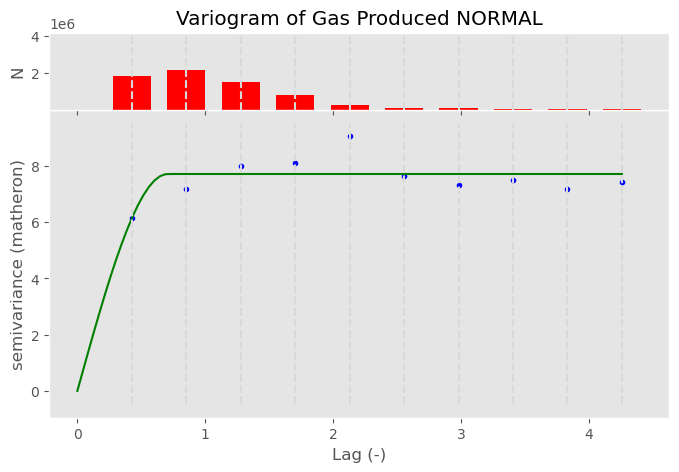

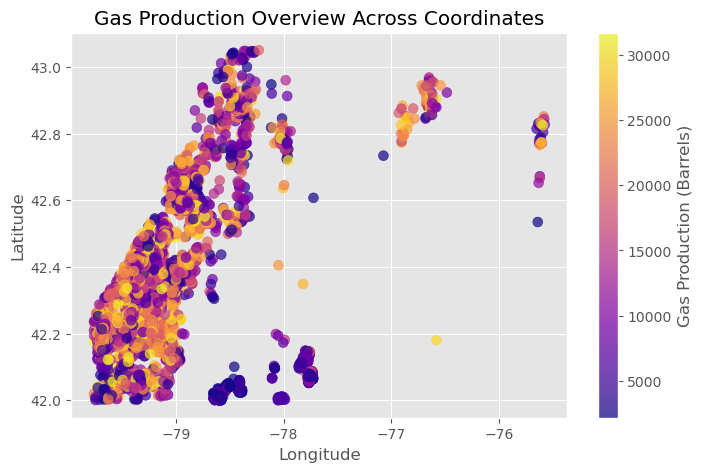

In [11]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

test_variogram = Variogram(
    coordinates=coordinates, 
    values=target)
pprint.pp(test_variogram.describe())

test_variogram.plot()
plt.title('Variogram of Gas Produced NORMAL')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(coordinates[:,0], coordinates[:,1], 
                       s=50, c=target, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Gas Production Overview Across Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Base Directional Variogram - No Detrend

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 4.213703923386633,
 'normalized_sill': 8510803381464747.0,
 'normalized_nugget': 0,
 'effective_range': 1.0339994721841113,
 'sill': 81027977.17911619,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


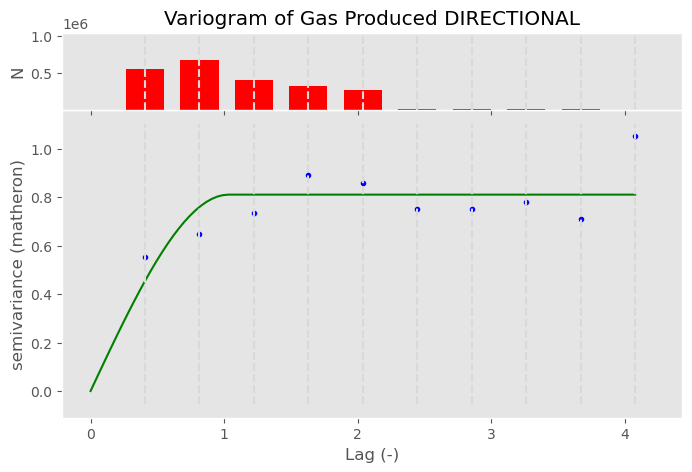

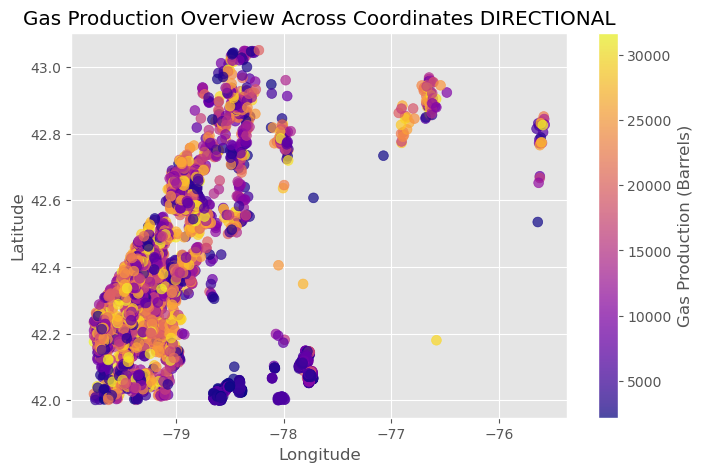

In [12]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

test_variogram = DirectionalVariogram(
    coordinates=coordinates, 
    values=target)
pprint.pp(test_variogram.describe())

test_variogram.plot()
plt.title('Variogram of Gas Produced DIRECTIONAL')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(coordinates[:,0], coordinates[:,1], 
                       s=50, c=target, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Gas Production Overview Across Coordinates DIRECTIONAL')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Linear Regression Detrended Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 13.512247961805793,
 'normalized_sill': 1.888716080695915e+16,
 'normalized_nugget': 0,
 'effective_range': 3.315766250918441,
 'sill': 114293914.49676274,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


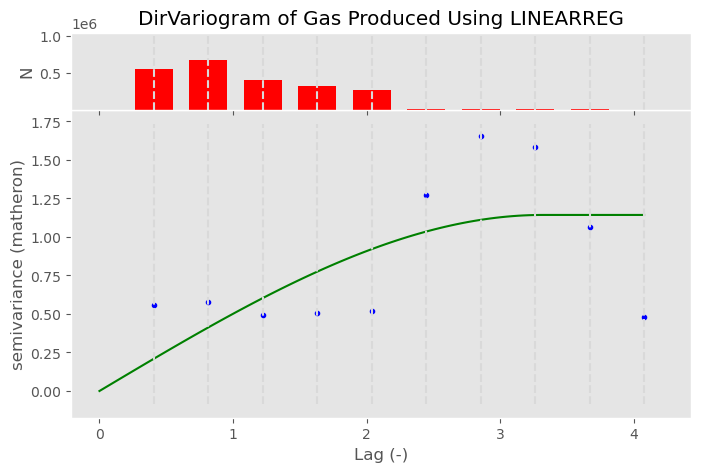

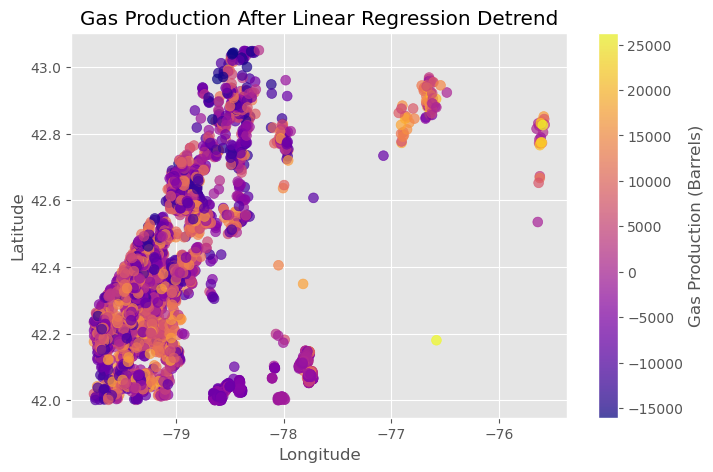

In [13]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

reg = LinearRegression().fit(coordinates, target)
trend = reg.predict(coordinates)
detrended_gas = target - trend

test_variogram = DirectionalVariogram(
    coordinates=coordinates,
    values=detrended_gas)
pprint.pp(test_variogram.describe())

test_variogram.plot()
plt.title('DirVariogram of Gas Produced Using LINEARREG')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(coordinates[:,0], coordinates[:,1], 
                       s=50, c=detrended_gas, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Gas Production After Linear Regression Detrend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Polynomial Regression Detrended Variogram

{'dist_func': 'euclidean',
 'effective_range': 3.526180886825677,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 14.369719363592369,
 'normalized_nugget': 0,
 'normalized_sill': 8482806636608083.0,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': None,
            'model': 'spherical',
            'n_lags': 10,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 85987858.6058897}


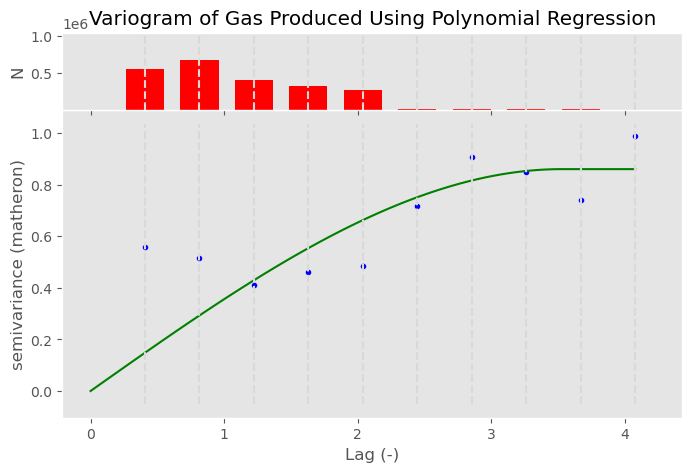

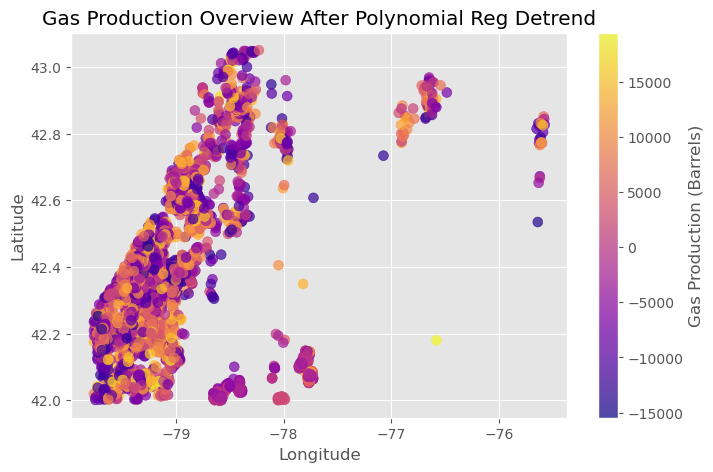

In [14]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

poly = PolynomialFeatures(degree=3, include_bias=False)
coordinates_poly = poly.fit_transform(coordinates)

reg = LinearRegression().fit(coordinates_poly, target)
trend = reg.predict(coordinates_poly)
detrended_gas = target - trend

test_variogram = DirectionalVariogram(
    coordinates=coordinates, 
    values=detrended_gas)
pprint.pprint(test_variogram.describe())

test_variogram.plot()
plt.title('Variogram of Gas Produced Using Polynomial Regression')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(coordinates[:,0], coordinates[:,1], 
                       s=50, c=detrended_gas, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Gas Production Overview After Polynomial Reg Detrend')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

### Detrend Preprocessing

##### `Polynomial regression was able to better capture the complex trend of the data more effectively leading to more stationary residuals, which is crucial for accurate kriging. Although the sill is slightly higher than the base directional variogram model meaning the variance is slightly higher with the residuals, but we were able to capture the stationarity through polynomial regression, key to kriging.`

#### Detrend Build

In [15]:
df = df_saved.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

poly = PolynomialFeatures(degree=3, include_bias=False)
coordinates_poly = poly.fit_transform(coordinates)

reg = LinearRegression().fit(coordinates_poly, target)
trend = reg.predict(coordinates_poly)
print(df['gas_prod'].describe())
detrended_gas = target - trend

df_detrended = df_saved.copy()
df_detrended['gas_prod'] = detrended_gas
print(df_detrended.describe())
pd.DataFrame(trend).to_csv('../data/trend_removed.csv', index=False)
print(pd.DataFrame(trend).describe())

count    3,691.00
mean    13,417.05
std      8,529.29
min      2,168.00
25%      5,756.00
50%     11,598.00
75%     20,423.50
max     31,710.00
Name: gas_prod, dtype: float64
        gas_prod    depth  elevation  longitude  latitude
count   3,691.00 3,691.00   3,691.00   3,691.00  3,691.00
mean        0.00 2,720.24   1,477.53     -78.79     42.33
std     7,447.12 1,061.56     468.29       0.68      0.28
min   -15,466.12   181.00       8.00     -79.76     42.00
25%    -5,118.49 1,838.00   1,150.00     -79.30     42.08
50%      -879.99 2,535.00   1,511.00     -78.93     42.27
75%     5,248.61 3,670.00   1,785.50     -78.43     42.53
max    19,445.32 6,412.00   2,398.00     -75.58     43.05
              0
count  3,691.00
mean  13,417.05
std    4,158.02
min    3,436.92
25%    8,584.07
50%   15,215.20
75%   16,649.10
max   18,192.07


In [17]:
df_detrended = df_detrended[['gas_prod','longitude','latitude','depth','elevation',
              'well','status','field','geology']]
df_detrended.head()

,gas_prod,longitude,latitude,depth,elevation,well,status,field,geology
0,"-8,186.21",-78.48,42.94,"1,294.00",851.00,gas development,plugged abandoned,Alden-Lancaster,Medina
1,"-12,104.63",-76.66,42.89,"1,818.00",535.00,gas development,plugged abandoned,West Auburn,Queenston
2,"14,721.52",-78.92,42.73,"1,425.00",640.00,gas development,inactive,Orchard Park-Hamburg,Medina
3,"-12,794.81",-79.31,42.27,"3,450.00","1,283.00",gas extension,plugged abandoned,Cassadaga Creek,Upper Devonian
4,"-9,290.20",-79.59,42.05,"4,500.00","1,780.00",oil wildcat,active,Clymer,Bass Island


#### Detrend Plot

{'dist_func': 'euclidean',
 'effective_range': 3.526180886825677,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 14.369719363592369,
 'normalized_nugget': 0,
 'normalized_sill': 8482806636608083.0,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': None,
            'model': 'spherical',
            'n_lags': 10,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 85987858.6058897}


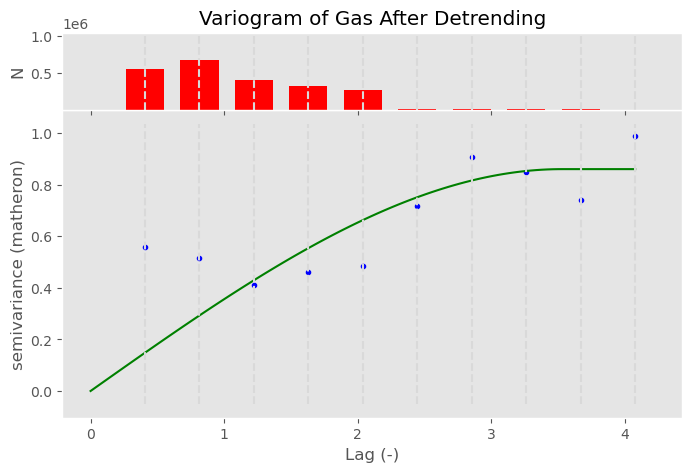

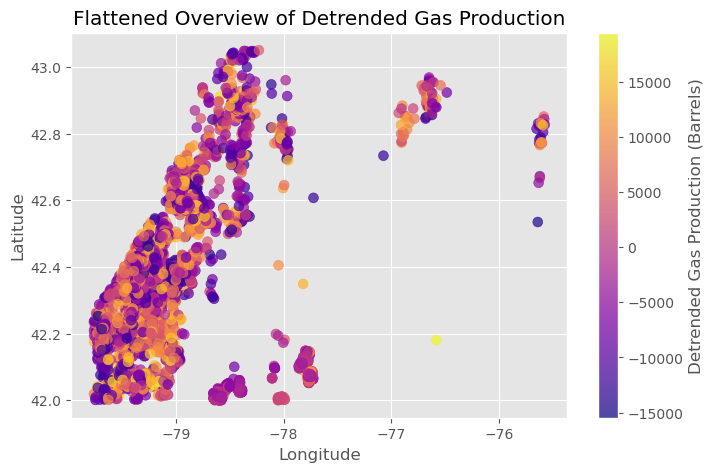

In [18]:
df = df_detrended.copy()
coordinates = np.array(df[['longitude','latitude']].values)
target = np.array(df['gas_prod'].values)

detrend_variogram = DirectionalVariogram(
    coordinates=coordinates, 
    values=target)
pprint.pprint(detrend_variogram.describe())

detrend_variogram.plot()
plt.title('Variogram of Gas After Detrending')

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(df['longitude'], df['latitude'], 
                       s=50, c=df['gas_prod'], cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Detrended Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

## Encoding Data

In [19]:
df = df_detrended.copy()
target = df['gas_prod']

numerical = ['gas_prod','longitude','latitude']
imperial = ['depth','elevation']
categorical = ['well','status','field','geology']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical),
        ('imp', StandardScaler(), imperial),
        ('cat', OneHotEncoder(sparse_output=False), categorical)])

df_transformed = preprocessor.fit_transform(df)
df_transformed = pd.DataFrame(df_transformed, columns=preprocessor.get_feature_names_out())
df_transformed.to_csv('../data/encoded_gaswells.csv', index=False)
print(df_transformed[['num__gas_prod','num__longitude','num__latitude',
                      'imp__depth','imp__elevation']].describe())
df_transformed

       num__gas_prod  num__longitude  num__latitude  imp__depth  \
count       3,691.00        3,691.00       3,691.00    3,691.00   
mean            0.00          -78.79          42.33        0.00   
std         7,447.12            0.68           0.28        1.00   
min       -15,466.12          -79.76          42.00       -2.39   
25%        -5,118.49          -79.30          42.08       -0.83   
50%          -879.99          -78.93          42.27       -0.17   
75%         5,248.61          -78.43          42.53        0.89   
max        19,445.32          -75.58          43.05        3.48   

       imp__elevation  
count        3,691.00  
mean             0.00  
std              1.00  
min             -3.14  
25%             -0.70  
50%              0.07  
75%              0.66  
max              1.97  


,num__gas_prod,num__longitude,num__latitude,imp__depth,imp__elevation,cat__well_gas development,cat__well_gas extension,cat__well_gas wildcat,cat__well_oil development,cat__well_oil wildcat,cat__status_active,cat__status_drilling complete,cat__status_inactive,cat__status_plugged abandoned,cat__status_shut in,cat__field_Akron,cat__field_Alden-Lancaster,cat__field_Allen,cat__field_Andover,cat__field_Ashford,cat__field_Attica,cat__field_Auburn,cat__field_Beaver Meadow - Vernon pool,cat__field_Beech Hill,cat__field_Beech Hill-Independence,cat__field_Bethany,cat__field_Bradford,cat__field_Bradley Brook,cat__field_Bradley Brook - Herkimer pool,cat__field_Brant-Eden,cat__field_Buffalo,cat__field_Buffalo Creek,cat__field_Busti,cat__field_Cagwin,cat__field_Cascade Brook,cat__field_Cassadaga Creek,cat__field_Castile,cat__field_Chaffee-Arcade,cat__field_Chestnut Ridge,cat__field_Chipmunk,cat__field_Clymer,cat__field_Concord,cat__field_Corbin Hill,cat__field_Cowlesville,cat__field_Danley Corners,cat__field_Dansville,cat__field_Dayton,cat__field_Dutch Hollow,cat__field_East Aurora,cat__field_East Otto,cat__field_Ellery,cat__field_Ellicotville,cat__field_Elma,cat__field_Fayette-Waterloo,cat__field_Five Mile,cat__field_Folsom Creek,cat__field_Four Mile,cat__field_Fulmer Valley,cat__field_Gerry-Charlotte,cat__field_Glenwood,cat__field_Gordon Brook,cat__field_Harmony,cat__field_Hog Hollow,cat__field_Huron Creek,cat__field_Indian Falls,cat__field_Java,cat__field_Karr Valley,cat__field_Lakeshore,cat__field_Lakeview,cat__field_Lebanon,cat__field_Leicester,cat__field_Longhorn - Hamilton Pool,cat__field_Mud Creek,cat__field_New Field Wildcat,cat__field_North Collins,cat__field_North Harmony,cat__field_North Penn Yan,cat__field_Olean,cat__field_Orchard Park-Hamburg,cat__field_Richburg,cat__field_Sardinia,cat__field_Sharon,cat__field_Sheldon,cat__field_Silver Lake,cat__field_Tozier's Corners,cat__field_Uhley Corners-Caledonia,cat__field_Utley Brook,cat__field_Van Etten,cat__field_Wales,cat__field_West Auburn,cat__field_West Seneca,cat__field_West Union,cat__geology_Akron,cat__geology_Bass Island,cat__geology_Bradford,cat__geology_Bradford & Chipmunk,cat__geology_Bradford 1st & Chipmunk,cat__geology_Bradford 2nd & 3rd,cat__geology_Bradford Second,cat__geology_Bradford Third,cat__geology_Chipmunk,cat__geology_Chipmunk & Bradford 2nd,cat__geology_Chipmunk & Bradford 3rd,cat__geology_Chipmunk & Harrisburg,"cat__geology_Chipmunk, Bradford 1st & 2nd","cat__geology_Chipmunk, Bradford 1st,2nd,3rd","cat__geology_Chipmunk, Bradford 2nd & 3rd",cat__geology_Clinton,cat__geology_Devonian Shale,cat__geology_Fulmer Valley,cat__geology_Glade,cat__geology_Grimsby,cat__geology_Hamilton,cat__geology_Herkimer,cat__geology_Herkimer-Oneida,cat__geology_Marcellus,cat__geology_Medina,cat__geology_Not Applicable,cat__geology_Oneida,cat__geology_Oneida-Oswego,cat__geology_Onondaga,cat__geology_Onondaga-Bass Island,cat__geology_Oriskany,cat__geology_Penny & Fulmer Valley,cat__geology_Queenston,cat__geology_Retsof,cat__geology_Richburg,cat__geology_Richburg-Waugh & Porter,cat__geology_Surficial,cat__geology_Theresa,cat__geology_Tully,cat__geology_Upper Devonian,cat__geology_Utica,cat__geology_Vernon,cat__geology_Waugh & Porter,cat__geology_Whirlpool
0,"-8,186.21",-78.48,42.94,-1.34,-1.34,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"-12,104.63",-76.66,42.89,-0.85,-2.01,1.00,0.0

## Model Preparation

In [20]:
df = pd.read_csv('../data/encoded_gaswells.csv')
print(f'Data Shape: {df.shape}')

coords = np.array(df[['num__longitude', 'num__latitude']].values)
vals = np.array(df['num__gas_prod'].values)

x = coords[:, 0]
y = coords[:, 1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]

x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

print(f'\
\nSplit Shapes\n------------\n\
coords:   {coords.shape}\n\
target:   {vals.shape}\n\
gridx:    {xx.shape}\n\
gridy:    {yy.shape}')

Data Shape: (3691, 136)

Split Shapes
------------
coords:   (3691, 2)
target:   (3691,)
gridx:    (100, 100)
gridy:    (100, 100)


## Ordinary Kriging

### Ordinary Kriging - Base Model

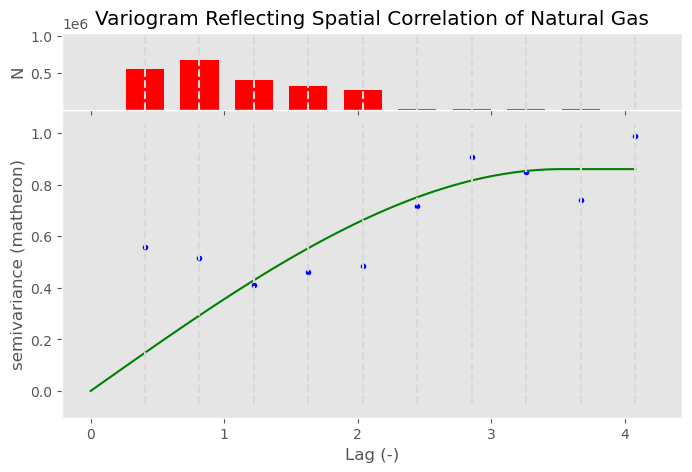

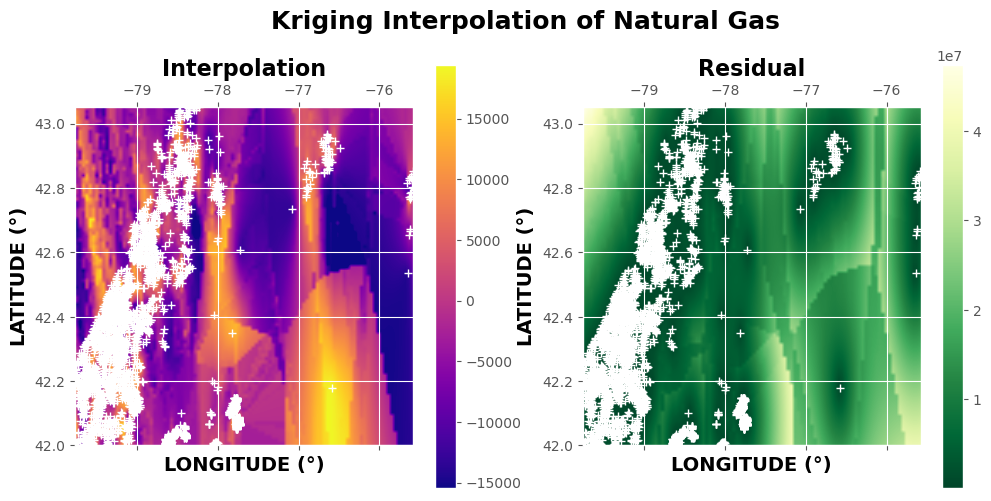

In [21]:
V = DirectionalVariogram(
    coordinates=coords,
    values=vals.flatten())

V.plot()
plt.title('Variogram Reflecting Spatial Correlation of Natural Gas')
plt.savefig('../images/base_variogram.png')

kriging = OrdinaryKriging(V)
field = kriging.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = kriging.sigma.reshape(xx.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5.5))
gas_interp = ax1.matshow(field.T, origin='lower', cmap='plasma', 
                   interpolation='bilinear',
                   vmin=vals.min(), vmax=vals.max(),
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax1.set_title('Interpolation', fontweight='bold', fontsize=16)
ax1.plot(x, y, '+w')
ax1.set_xlabel('LONGITUDE (°)', color='black', fontweight='bold', fontsize=14)
ax1.set_ylabel('LATITUDE (°)', color='black', fontweight='bold', fontsize=14)
ax1.set_xlim((x.min(), x.max()))
ax1.set_ylim((y.min(), y.max()))
ax1.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax1.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(gas_interp, ax=ax1)

gas_error = ax2.matshow(s2.T, origin='lower', cmap='YlGn_r',
                   interpolation='bilinear',
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax2.set_title('Residual', fontweight='bold', fontsize=16)
ax2.plot(x, y, '+w')
ax2.set_xlabel('LONGITUDE (°)', color='black', fontweight='bold', fontsize=14)
ax2.set_ylabel('LATITUDE (°)', color='black', fontweight='bold', fontsize=14)
ax2.set_xlim((x.min(), x.max()))
ax2.set_ylim((y.min(), y.max()))
ax2.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax2.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(gas_error, ax=ax2)

fig.suptitle('Kriging Interpolation of Natural Gas\n\n', fontsize=18, fontweight='bold')
plt.show()
plt.tight_layout(rect=[0,0,1,0.95])
fig.savefig('../images/base_ordinary.png')
plt.close()

with open('../model/base_ordinary.pkl', 'wb') as file:
    pickle.dump(kriging, file)

### Ordinary Kriging - Hyperparameter Tuning

In [12]:
param_dist = {
    'min_points': range(10, 21),
    'max_points': range(20, 41),
    'mode': ['exact', 'estimate'],
    'precision': range(75, 126),
    'n_lags': range(10, 21),
    'model': ['spherical', 'exponential', 'gaussian'],
    'azimuth': [0, 45, 90, 135, 180],
    'tolerance': [30.0, 45.0, 60.0],
    'bandwidth': ['q33', 'q50', 'q67']}

randsearch_iter = 20
randsearch_params = list(ParameterSampler(param_dist, n_iter=randsearch_iter, random_state=42))

best_params = None
best_score = np.inf

for params in randsearch_params:
    V = DirectionalVariogram(
        coordinates=coords,
        values=vals.flatten(),
        model=params['model'],
        n_lags=params['n_lags'],
        azimuth=params['azimuth'],
        tolerance=params['tolerance'],
        bandwidth=params['bandwidth'])

    kriging = OrdinaryKriging(
        V,
        min_points=params['min_points'],
        max_points=params['max_points'],
        mode=params['mode'],
        precision=params['precision'])

    score = jacknife(V, metric='rmse')
    if score < best_score:
        best_score = score
        best_params = params

print('RandomizedSearch')
print(best_params)
print(best_score)

param_grid = {
    'min_points': [best_params['min_points'] - 2, 
                   best_params['min_points'], 
                   best_params['min_points'] + 2],
    'max_points': [best_params['max_points'] - 5, 
                   best_params['max_points'], 
                   best_params['max_points'] + 5],
    'precision': [best_params['precision'] - 10, 
                  best_params['precision'], 
                  best_params['precision'] + 10],
    'n_lags': [best_params['n_lags'] - 2, 
               best_params['n_lags'], 
               best_params['n_lags'] + 2],
    'azimuth': [best_params['azimuth']],
    'tolerance': [best_params['tolerance']],
    'bandwidth': [best_params['bandwidth']],
    'mode': [best_params['mode']],
    'model': [best_params['model']]}

gridsearch_params = list(ParameterGrid(param_grid))

best_params = None
best_score = np.inf

for params in gridsearch_params:
    V = DirectionalVariogram(
        coordinates=coords,
        values=vals.flatten(),
        model=params['model'],
        n_lags=params['n_lags'],
        azimuth=params['azimuth'],
        tolerance=params['tolerance'],
        bandwidth=params['bandwidth'])

    kriging = OrdinaryKriging(
        V,
        min_points=params['min_points'],
        max_points=params['max_points'],
        mode=params['mode'],
        precision=params['precision'])

    score = jacknife(V, metric='rmse')
    if score < best_score:
        best_score = score
        best_params = params

print('GridSearch')
print(best_params)
print(best_score)

### Ordinary Kriging - Tuned Model

In [13]:
tuned_variogram = DirectionalVariogram(
    coordinates=coords,
    values=vals.flatten(),
    model=best_params['model'],
    n_lags=best_params['n_lags'],
    azimuth=best_params['azimuth'],
    tolerance=best_params['tolerance'],
    bandwidth=best_params['bandwidth'])

tuned_variogram.plot()
plt.title('Variogram of Gas')
plt.savefig('../images/tuned_variogram.png')

tuned_kriging = OrdinaryKriging(
    tuned_variogram,
    min_points=best_params['min_points'],
    max_points=best_params['max_points'],
    mode=best_params['mode'],
    precision=best_params['precision'])

field = tuned_kriging.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
field = np.nan_to_num(field, nan=0.0)
s2 = tuned_kriging.sigma.reshape(xx.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
gas_interp = ax1.matshow(field.T, origin='lower', cmap='plasma', 
                   interpolation='bilinear',
                   vmin=vals.min(), vmax=vals.max(),
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax1.set_title('Interpolation')
ax1.plot(x, y, '+w')
ax1.set_xlabel('LONGITUDE (°)', color='black')
ax1.set_ylabel('LATITUDE (°)', color='black')
ax1.set_xlim((x.min(), x.max()))
ax1.set_ylim((y.min(), y.max()))
ax1.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax1.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(gas_interp, ax=ax1)

gas_error = ax2.matshow(s2.T, origin='lower', cmap='YlGn_r',
                   interpolation='bilinear',
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax2.set_title('Residual')
ax2.plot(x, y, '+w')
ax2.set_xlabel('LONGITUDE (°)', color='black')
ax2.set_ylabel('LATITUDE (°)', color='black')
ax2.set_xlim((x.min(), x.max()))
ax2.set_ylim((y.min(), y.max()))
ax2.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax2.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(gas_error, ax=ax2)

plt.suptitle('Tuned Kriging Interpolation of Natural Gas\n', fontsize=16, fontweight='bold')
plt.show()
plt.tight_layout(rect=[0,0,1,1])
fig.savefig('../images/tuned_ordinary.png')
plt.close()

with open('../model/tuned_ordinary.pkl', 'wb') as file:
    pickle.dump(tuned_kriging, file)

## Regression Kriging

### Model Preparation

In [23]:
external_drift

array([[-1.34371841, -1.33808893,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.85003607, -2.01297333,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.22029783, -1.78872377,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.35823802, -1.55379565,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.3083045 , -1.51108145,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.60469171, -0.89172551,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [25]:
df = pd.read_csv('../data/encoded_gaswells.csv')
print('df.shape\n------------')
print(df.shape)

multivariate = []
for feature in df.columns:
    if feature not in ['num__gas_prod','num__longitude','num__latitude']:
        multivariate.append(feature)

print('\nexternal_drift\n------------')
external_drift = df[multivariate].values
print(len(multivariate))

x = df[['num__longitude', 'num__latitude']].values
p = external_drift
target = df['num__gas_prod'].values

p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
    p, x, target, test_size=0.3, random_state=42)

svr_model = SVR()
rf_model = RandomForestRegressor()
lr_model = LinearRegression()

print_shape = [p_train, p_test, x_train, x_test, target_train, target_test]
print('\ntrain_test_split\n------------')
for shape in print_shape:
    print(shape.shape)

print('\nmodels\n------------')
print(svr_model, rf_model, lr_model)

df.head()

df.shape
------------
(3691, 136)

external_drift
------------
133

train_test_split
------------
(2583, 133)
(1108, 133)
(2583, 2)
(1108, 2)
(2583,)
(1108,)

models
------------
SVR() RandomForestRegressor() LinearRegression()


,num__gas_prod,num__longitude,num__latitude,imp__depth,imp__elevation,cat__well_gas development,cat__well_gas extension,cat__well_gas wildcat,cat__well_oil development,cat__well_oil wildcat,cat__status_active,cat__status_drilling complete,cat__status_inactive,cat__status_plugged abandoned,cat__status_shut in,cat__field_Akron,cat__field_Alden-Lancaster,cat__field_Allen,cat__field_Andover,cat__field_Ashford,cat__field_Attica,cat__field_Auburn,cat__field_Beaver Meadow - Vernon pool,cat__field_Beech Hill,cat__field_Beech Hill-Independence,cat__field_Bethany,cat__field_Bradford,cat__field_Bradley Brook,cat__field_Bradley Brook - Herkimer pool,cat__field_Brant-Eden,cat__field_Buffalo,cat__field_Buffalo Creek,cat__field_Busti,cat__field_Cagwin,cat__field_Cascade Brook,cat__field_Cassadaga Creek,cat__field_Castile,cat__field_Chaffee-Arcade,cat__field_Chestnut Ridge,cat__field_Chipmunk,cat__field_Clymer,cat__field_Concord,cat__field_Corbin Hill,cat__field_Cowlesville,cat__field_Danley Corners,cat__field_Dansville,cat__field_Dayton,cat__field_Dutch Hollow,cat__field_East Aurora,cat__field_East Otto,cat__field_Ellery,cat__field_Ellicotville,cat__field_Elma,cat__field_Fayette-Waterloo,cat__field_Five Mile,cat__field_Folsom Creek,cat__field_Four Mile,cat__field_Fulmer Valley,cat__field_Gerry-Charlotte,cat__field_Glenwood,cat__field_Gordon Brook,cat__field_Harmony,cat__field_Hog Hollow,cat__field_Huron Creek,cat__field_Indian Falls,cat__field_Java,cat__field_Karr Valley,cat__field_Lakeshore,cat__field_Lakeview,cat__field_Lebanon,cat__field_Leicester,cat__field_Longhorn - Hamilton Pool,cat__field_Mud Creek,cat__field_New Field Wildcat,cat__field_North Collins,cat__field_North Harmony,cat__field_North Penn Yan,cat__field_Olean,cat__field_Orchard Park-Hamburg,cat__field_Richburg,cat__field_Sardinia,cat__field_Sharon,cat__field_Sheldon,cat__field_Silver Lake,cat__field_Tozier's Corners,cat__field_Uhley Corners-Caledonia,cat__field_Utley Brook,cat__field_Van Etten,cat__field_Wales,cat__field_West Auburn,cat__field_West Seneca,cat__field_West Union,cat__geology_Akron,cat__geology_Bass Island,cat__geology_Bradford,cat__geology_Bradford & Chipmunk,cat__geology_Bradford 1st & Chipmunk,cat__geology_Bradford 2nd & 3rd,cat__geology_Bradford Second,cat__geology_Bradford Third,cat__geology_Chipmunk,cat__geology_Chipmunk & Bradford 2nd,cat__geology_Chipmunk & Bradford 3rd,cat__geology_Chipmunk & Harrisburg,"cat__geology_Chipmunk, Bradford 1st & 2nd","cat__geology_Chipmunk, Bradford 1st,2nd,3rd","cat__geology_Chipmunk, Bradford 2nd & 3rd",cat__geology_Clinton,cat__geology_Devonian Shale,cat__geology_Fulmer Valley,cat__geology_Glade,cat__geology_Grimsby,cat__geology_Hamilton,cat__geology_Herkimer,cat__geology_Herkimer-Oneida,cat__geology_Marcellus,cat__geology_Medina,cat__geology_Not Applicable,cat__geology_Oneida,cat__geology_Oneida-Oswego,cat__geology_Onondaga,cat__geology_Onondaga-Bass Island,cat__geology_Oriskany,cat__geology_Penny & Fulmer Valley,cat__geology_Queenston,cat__geology_Retsof,cat__geology_Richburg,cat__geology_Richburg-Waugh & Porter,cat__geology_Surficial,cat__geology_Theresa,cat__geology_Tully,cat__geology_Upper Devonian,cat__geology_Utica,cat__geology_Vernon,cat__geology_Waugh & Porter,cat__geology_Whirlpool
0,"-8,186.21",-78.48,42.94,-1.34,-1.34,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"-12,104.63",-76.66,42.89,-0.85,-2.01,1.00,0.0

### Regression Kriging - Base Model

In [26]:
variogram_model = V.model.__name__
variogram_params = {
    'sill': V.parameters[0], 
    'range': V.parameters[1], 
    'nugget': V.parameters[2] if len(V.parameters) > 2 else 0.0 }

models = [svr_model, rf_model, lr_model]
for model in models:
    print('=' * 40)
    print(f'Model: {model.__class__.__name__}')
    
    test_rk = RegressionKriging(
        regression_model=model,
        verbose=True,
        variogram_model=variogram_model,
        variogram_parameters=variogram_params)
    
    test_rk.fit(p_train, x_train, target_train)
    print('Reg Score:', test_rk.regression_model.score(p_test, target_test))
    print('RK Score:', test_rk.score(p_test, x_test, target_test))

print('=' * 40)
rk_model = RegressionKriging(
        regression_model=RandomForestRegressor(),
        verbose=True,
        variogram_model=variogram_model,
        variogram_parameters=variogram_params)

rk_model.fit(p_train, x_train, target_train)
pred = rk_model.predict(p_test, x_test)
df_pred = pd.DataFrame({'gasprod_actual': target_test, 'gasprod_predicted': pred})
df_pred.to_csv('../data/pred_gaswells.csv', index=False)

print('Reg Score:', rk_model.regression_model.score(p_test, target_test))
print('RK Score:', rk_model.score(p_test, x_test, target_test))

with open('../model/base_regkrig.pkl', 'wb') as file:
    pickle.dump(rk_model, file)

Model: SVR
Finished learning regression model
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 3.526180886825677
Full Sill: 3.526180886825677
Range: 85987858.6058897
Nugget: 0 

Calculating statistics on variogram model fit...
Finished kriging residuals
Reg Score: -0.014676900998154663
Executing Ordinary Kriging...

RK Score: 0.07826439035926636
Model: RandomForestRegressor
Finished learning regression model
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 3.526180886825677
Full Sill: 3.526180886825677
Range: 85987858.6058897
Nugget: 0 

Calculating statistics on variogram model fit...
Finished kriging residuals
Reg Score: -0.049579034271190814
Executing Ordinary Kriging...

RK Score: 0.01473149951917374
Model: LinearRegression
Finished learning regression model
Adjusting data for anisotropy...
In

### Regression Kriging - Hyperparameter Tuning

In [33]:
param_dist = {
    'regression_model': [svr_model, rf_model, lr_model],
    'variogram_model': ['linear', 'power', 'spherical', 'gaussian'],
    'n_closest_points': [5, 10, 20],
    'nlags': [6, 10, 14],
    'anisotropy_scaling': [(1.0, 1.0), (1.1, 1.0), (1.2, 1.0)],
    'anisotropy_angle': [(0.0, 0.0, 0.0), (15.0, 0.0, 0.0), (30.0, 0.0, 0.0)],
    'ext_drift_grid': (external_drift.flatten(), x, y) }

randsearch_iter = 10
randsearch_params = list(ParameterSampler(param_dist, n_iter=randsearch_iter, random_state=42))

best_params = None
best_score = -np.inf

for params in randsearch_params:
    print('=' * 40)
    print(f"Model: { params['regression_model'] }")
    
    rk_model = RegressionKriging(
        regression_model=params['regression_model'],
        variogram_model=params['variogram_model'],
        n_closest_points=params['n_closest_points'],
        nlags=params['nlags'],
        anisotropy_scaling=params['anisotropy_scaling'],
        anisotropy_angle=params['anisotropy_angle'],
        ext_drift_grid=(external_drift.flatten(), x, y))
    
    rk_model.fit(p_train, x_train, target_train)
    
    score = rk_model.score(p_test, x_test, target_test)
    print('RK Score:', score)
    
    if score > best_score:
        best_score = score
        best_params = params

param_grid = {
    'regression_model': [best_params['regression_model']],
    'variogram_model': [best_params['variogram_model']],
    'n_closest_points': [best_params['n_closest_points'] - 1, 
                         best_params['n_closest_points'], 
                         best_params['n_closest_points'] + 1],
    'nlags': [best_params['nlags'] - 2, 
              best_params['nlags'], 
              best_params['nlags'] + 2],
    'anisotropy_scaling': [(1.0, 1.0), 
                           (best_params['anisotropy_scaling']), 
                           (best_params['anisotropy_scaling'][0] * 1.05, best_params['anisotropy_scaling'][1])],
    'anisotropy_angle': [(0.0, 0.0, 0.0), 
                         best_params['anisotropy_angle'], 
                         (best_params['anisotropy_angle'][0] + 5, 0.0, 0.0)]}

gridsearch_params = list(ParameterGrid(param_grid))

for params in gridsearch_params:
    print('=' * 40)
    print(f"Model: { params['regression_model'] }")

    rk_model = RegressionKriging(
        regression_model=params['regression_model'],
        variogram_model=params['variogram_model'],
        n_closest_points=params['n_closest_points'],
        nlags=params['nlags'],
        anisotropy_scaling=params['anisotropy_scaling'],
        anisotropy_angle=params['anisotropy_angle'],
        ext_drift_grid=(external_drift.flatten(), x, y))
    
    rk_model.fit(p_train, x_train, target_train)
    score = rk_model.score(p_test, x_test, target_test)
    print('RK Score:', score)
    
    if score > best_score:
        best_score = score
        best_params = params

print('Regression Kriging')
print(best_score)
print(best_params)

Model: LinearRegression()
Finished learning regression model
Finished kriging residuals
RK Score: -5.5021754528826386e+20
Model: LinearRegression()
Finished learning regression model
Finished kriging residuals
RK Score: -5.502175452881419e+20
Model: SVR()
Finished learning regression model
Finished kriging residuals
RK Score: 0.14213732154533087
Model: SVR()
Finished learning regression model
Finished kriging residuals
RK Score: 0.1254094704656591
Model: RandomForestRegressor()
Finished learning regression model
Finished kriging residuals
RK Score: 0.028439789812236493
Model: LinearRegression()
Finished learning regression model
Finished kriging residuals
RK Score: -5.5021754528769534e+20
Model: LinearRegression()
Finished learning regression model
Finished kriging residuals
RK Score: -5.502175452879778e+20
Model: SVR()
Finished learning regression model
Finished kriging residuals
RK Score: 0.14213732154533087
Model: RandomForestRegressor()
Finished learning regression model
Finished k

### Regression Kriging - Tuned Model

In [34]:
tuned_rk = RegressionKriging(
    regression_model=best_params['regression_model'],
    variogram_model=best_params['variogram_model'],
    n_closest_points=best_params['n_closest_points'],
    nlags=best_params['nlags'],
    anisotropy_scaling=best_params['anisotropy_scaling'],
    anisotropy_angle=best_params['anisotropy_angle'],
    verbose=True,
    ext_drift_grid=(external_drift.flatten(), x, y),
    enable_statistics=True)

tuned_rk.fit(p_train, x_train, target_train)
reg_score = tuned_rk.regression_model.score(p_test, target_test)
rk_score = tuned_rk.score(p_test, x_test, target_test)

print('Tuned Regression Kriging')
print(reg_score)
print(rk_score)

pred = tuned_rk.predict(p_test, x_test)
print(pred)
df_pred = pd.DataFrame({'gasprod_test': target_test, 'pred_gasprod': pred})
df_pred.to_csv('../data/pred_gaswells.csv')

with open('../model/tuned_regkrig.pkl', 'wb') as file:
    pickle.dump(tuned_rk, file)

Finished learning regression model
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 28344670.332295306
Full Sill: 73530022.67595492
Range: 4.027379501086885
Nugget: 45185352.34365962 

Calculating statistics on variogram model fit...
Q1 = 0.016637975589031656
Q2 = 1.1168105868573441
cR = 52110021.31985605 

Finished kriging residuals
Executing Ordinary Kriging...

Tuned Regression Kriging
-0.014676900998154663
0.14223571686100023
Executing Ordinary Kriging...

[7031.92777765 -853.52406771 8240.57703442 ... 1765.21256215 1971.90562412
  256.99484568]


## CoKriging

### Model Preparation

In [14]:
df = pd.read_csv('../data/encoded_gaswells.csv')
print('df.shape\n------------')
print(df.shape)

x = df['num__longitude'].values
y = df['num__latitude'].values
z = df['num__gas_prod'].values

x_ = (x - x.min()) / (x.max() - x.min()) * 25
y_ = (y - y.min()) / (y.max() - y.min()) * 25

xx, yy = np.mgrid[x.min():x.max():25j, y.min():y.max():25j]

multivariate = []
for feature in df.columns:
    if feature not in ['num__gas_prod','num__longitude','num__latitude']:
        multivariate.append(feature)

print('\nexternal_drift\n------------')
print(len(multivariate))
external_drift = df[multivariate].values

df.head()

### CoKriging - Base Model

In [15]:
co_kriging = UniversalKriging(
    x=x,
    y=y,
    z=z,
    variogram_model='spherical',
    external_drift=external_drift.flatten(),
    external_drift_x=x,
    external_drift_y=y,
    verbose=True,
    enable_plotting=True)

z_pred, s2_error = co_kriging.execute('grid', xx, yy)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
uk_interp = ax1.matshow(z_pred.T, origin='lower', cmap='plasma', 
                   interpolation='bilinear',
                   vmin=z.min(), vmax=z.max(),
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax1.set_title('Interpolation')
ax1.plot(x, y, '+w')
ax1.set_xlabel('LONGITUDE (°)', color='black')
ax1.set_ylabel('LATITUDE (°)', color='black')
ax1.set_xlim((x.min(), x.max()))
ax1.set_ylim((y.min(), y.max()))
ax1.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax1.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(uk_interp, ax=ax1)

uk_error = ax2.matshow(s2_error.T, origin='lower', cmap='YlGn_r',
                   interpolation='bilinear',
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax2.set_title('Residual')
ax2.plot(x, y, '+w')
ax2.set_xlabel('LONGITUDE (°)', color='black')
ax2.set_ylabel('LATITUDE (°)', color='black')
ax2.set_xlim((x.min(), x.max()))
ax2.set_ylim((y.min(), y.max()))
ax2.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax2.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(uk_error, ax=ax2)

plt.suptitle('Kriging Interpolation of Natural Gas\n\n', fontsize=16, fontweight='bold')
plt.show()
plt.tight_layout(rect=[0,0,1,1])
fig.savefig('../images/base_cokriging.png')
plt.close()

with open('../model/base_cokriging.pkl', 'wb') as file:
    pickle.dump(co_kriging, file)

### CoKriging - Hyperparameter Tuning

In [16]:
param_dist = {
    'variogram_model': ['linear', 'power', 'gaussian', 'spherical', 'exponential'],
    'nlags': np.arange(6, 12),
    'anisotropy_scaling': np.linspace(0.5, 2.5, 10),
    'anisotropy_angle': np.linspace(0.0, 180.0, 10),
    'weight': [True, False],
    'pseudo_inv': [True, False]}

randsearch_iter = 15
randsearch_params = list(ParameterSampler(param_dist, n_iter=randsearch_iter, random_state=42))

best_params = None
best_score = np.inf

for params in randsearch_params:
    uk = UniversalKriging(
        x=x,
        y=y,
        z=z,
        variogram_model=params['variogram_model'],
        nlags=params['nlags'],
        anisotropy_scaling=params['anisotropy_scaling'],
        anisotropy_angle=params['anisotropy_angle'],
        weight=params['weight'],
        external_drift=external_drift.flatten(),
        external_drift_x=x,
        external_drift_y=y,
        pseudo_inv=params['pseudo_inv'],
        verbose=False,
        enable_plotting=False)
    
    z_pred, _ = uk.execute('points', x, y)
    mse = mean_squared_error(z, z_pred.flatten())
    
    if mse < best_score:
        best_score = mse
        best_params = params

print('RandomizedSearch')
print(best_params)
print(best_score)

param_grid = {
    'nlags': [best_params['nlags'] - 1, 
              best_params['nlags'], 
              best_params['nlags'] + 1],
    'anisotropy_scaling': np.linspace(
        best_params['anisotropy_scaling'] * 0.9,
        best_params['anisotropy_scaling'] * 1.1,
        5),
    'anisotropy_angle': np.linspace(
        best_params['anisotropy_angle'] - 10,
        best_params['anisotropy_angle'] + 10,
        5)}

best_grid_params = None
best_grid_score = np.inf

gridsearch_params = list(ParameterGrid(param_grid))
for params in gridsearch_params:
    uk = UniversalKriging(
        x=x,
        y=y,
        z=z,
        variogram_model=best_params['variogram_model'],  # Fixed from random search
        nlags=params['nlags'],
        anisotropy_scaling=params['anisotropy_scaling'],
        anisotropy_angle=params['anisotropy_angle'],
        weight=best_params['weight'],  # Fixed from random search
        external_drift=external_drift.flatten(),
        external_drift_x=x,
        external_drift_y=y,
        pseudo_inv=best_params['pseudo_inv'],  # Fixed from random search
        verbose=False,
        enable_plotting=False)
    
    z_pred, _ = uk.execute('points', x, y)
    mse = mean_squared_error(z, z_pred.flatten())
    
    if mse < best_grid_score:
        best_grid_score = mse
        best_grid_params = params

print('GridSearch')
print(best_params)
print(best_score)

### CoKriging - Tuned Model

In [17]:
tuned_uk = UniversalKriging(
    x=x,
    y=y,
    z=z,
    variogram_model=best_params['variogram_model'],
    nlags=best_grid_params['nlags'],
    anisotropy_scaling=best_grid_params['anisotropy_scaling'],
    anisotropy_angle=best_grid_params['anisotropy_angle'],
    weight=best_params['weight'],
    external_drift=external_drift.flatten(),
    external_drift_x=x,
    external_drift_y=y,
    pseudo_inv=best_params['pseudo_inv'],
    verbose=True,
    enable_plotting=True)

z_pred, s2_error = tuned_uk.execute('grid', xx, yy)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
uk_interp = ax1.matshow(z_pred.T, origin='lower', cmap='plasma', 
                   interpolation='bilinear',
                   vmin=z.min(), vmax=z.max(),
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax1.set_title('Interpolation')
ax1.plot(x, y, '+w')
ax1.set_xlabel('LONGITUDE (°)', color='black')
ax1.set_ylabel('LATITUDE (°)', color='black')
ax1.set_xlim((x.min(), x.max()))
ax1.set_ylim((y.min(), y.max()))
ax1.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax1.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(uk_interp, ax=ax1)

uk_error = ax2.matshow(s2_error.T, origin='lower', cmap='YlGn_r',
                   interpolation='bilinear',
                   extent=[x.min(), x.max(), y.min(), y.max()])
ax2.set_title('Residual')
ax2.plot(x, y, '+w')
ax2.set_xlabel('LONGITUDE (°)', color='black')
ax2.set_ylabel('LATITUDE (°)', color='black')
ax2.set_xlim((x.min(), x.max()))
ax2.set_ylim((y.min(), y.max()))
ax2.set_yticks(np.arange(y.min(), y.max(), 0.2))
ax2.set_aspect(abs(x.max()-x.min())/abs(y.max()-y.min()))
plt.colorbar(uk_error, ax=ax2)

plt.suptitle('Kriging Interpolation of Natural Gas\n\n', fontsize=16, fontweight='bold')
plt.show()
plt.tight_layout(rect=[0,0,1,1])
fig.savefig('../images/tuned_cokriging.png')
plt.close()

with open('../model/tuned_cokriging.pkl', 'wb') as file:
    pickle.dump(tuned_uk, file)

## Script

In [ ]:
try:
    print('Script executed successfully.')
except:
    print('FAILED')